#### 🔰Cet projet consiste à prédire si un client de Telecom va se désabonner ou pas. Ceci est une notebook de recherche qui nous servira à faire l'analyse exploratoire des données de l'entreprise afin de pouvoir créer un modèle de machine learning capable de prédire si un client se désabonnera ou non.

#### ⚜💢Je me nomme Chrystal Orian VIGAN. Je suis datascientiste. Email: viganchrystal@gmail.com

##### ⏸Début de projet: 18/03/2024

### 📑Steps
 #####  1- Analyse exploratoire des données (EDA)
 #####  2- Pre-traitement des donnees (Preprocessing)
 #####  3- Création des modèles de ML

In [59]:
# Importation des modules

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector 
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier



import joblib


In [3]:
# IMPORTATION DE NOTRE DATASET

Data = pd.read_csv('./data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

### Visualisation du dataset

In [4]:
df = Data.copy()

df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
print('Shape', df.shape)
print('\n')
print(df.describe())

Shape (7043, 21)


       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


object     18
int64       2
float64     1
Name: count, dtype: int64


Axes(0.22375,0.11;0.5775x0.77)


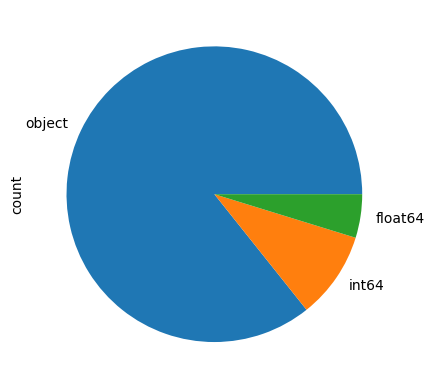

In [7]:
print(df.dtypes.value_counts())
print('\n')
print(df.dtypes.value_counts().plot.pie())

In [8]:
df['customerID'].nunique()

7043

In [9]:
df['customerID'].nunique() == df.shape[0]

# #Nous constatons que la colonne 'customerID' est l'identifiant de chaque client au niveau de l'entreprise. Alors elle ne nous apportera aucune information dans l'analyse et la prédiction dans ce cas

True

In [10]:
df = df.drop('customerID', axis=1)

print(df.shape)
print('\n')
df.columns.to_list()

(7043, 20)




['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn']

In [11]:
df.isna().sum()

# Nous constatons qu'il y a pas de valeur manquante dans notre dataframe

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [12]:
# Ici, notre variable cible est la variable Chrun
# Nous sommes face à un problème de classification

df['Churn'].unique()

array(['No', 'Yes'], dtype=object)

In [13]:
# Nous constatons qu'il y a un déséquilibre de classe. Les clients qui se sont désabonner font environ 25% des clients

df['Churn'].value_counts(normalize=True)

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

In [14]:
df['Churn'] = df['Churn'].apply(lambda val: 0 if val == 'No' else 1)

In [15]:
df.dtypes.value_counts()

object     16
int64       3
float64     1
Name: count, dtype: int64

In [16]:
# Nous allos couper le dataset en trois partir: un trainset qui va servir pour l'entrainement, un validate pour servir tester notre model et un test pour servi pour une première prédiction.

seed = 123

trainset, test = train_test_split(df, test_size=0.3, random_state=seed, stratify=df['Churn'])
test, validate = train_test_split(test, test_size=0.5, random_state=seed, stratify=test['Churn'])

In [17]:
# Enregistrement des Jeux de données dans un dossier data 

trainset.to_csv('./data/train.csv', index=False)
test.to_csv('./data/test.csv', index=False)
validate.to_csv('./data/validate.csv', index=False)

### EDA

In [18]:
# Nous allons créer une copie de notre trainset pour prétraiter et entrainer notre premier model de ML

train = trainset.copy()

In [19]:
# Nous allons créer deux sous ensembles categorical et numerical pour pouvoir séparer les données numérique d'avec les données categorielles pour pouvoirs mieux les analyser

categorical = train.select_dtypes(include='object')
numerical = train.select_dtypes(exclude='object')

In [20]:
for col in categorical:
    print(f'{col :-<50} {train[col].unique()}')

gender-------------------------------------------- ['Male' 'Female']
Partner------------------------------------------- ['Yes' 'No']
Dependents---------------------------------------- ['Yes' 'No']
PhoneService-------------------------------------- ['Yes' 'No']
MultipleLines------------------------------------- ['No' 'Yes' 'No phone service']
InternetService----------------------------------- ['Fiber optic' 'No' 'DSL']
OnlineSecurity------------------------------------ ['No' 'Yes' 'No internet service']
OnlineBackup-------------------------------------- ['Yes' 'No' 'No internet service']
DeviceProtection---------------------------------- ['No' 'Yes' 'No internet service']
TechSupport--------------------------------------- ['Yes' 'No' 'No internet service']
StreamingTV--------------------------------------- ['Yes' 'No internet service' 'No']
StreamingMovies----------------------------------- ['No' 'Yes' 'No internet service']
Contract------------------------------------------ ['Month-to-

 Nous constatons que la variable 'TotalCharges' est de types float mais la machine la considère comme une varibles de types objet....
 Nous allons bien l'analyser et voir la raison

In [21]:
print(train['TotalCharges'].dtype)

print(train['TotalCharges'].head(5))

object
4890    4779.45
511     6300.15
169       321.4
3649    1847.55
1568    1183.05
Name: TotalCharges, dtype: object


In [22]:
train['TotalCharges'].isnull().value_counts()

TotalCharges
False    4930
Name: count, dtype: int64

In [23]:
# Nous allons forcé et convertir la variable en une variable numérique et voir les valeurs qui ne seront pas convertir
try:
    pd.to_numeric(train['TotalCharges'], errors='raise')
except ValueError as e:
    print(f"Error: {e}")

Error: Unable to parse string " " at position 120


Nous avons constaté ce sont des chaines de caractère vide " " qui sont à la base du problème. Dans la partir du pretraitement, nous alons forcé et remplacer ces valeurs par des valeus manquantes

c:\Users\vigan\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


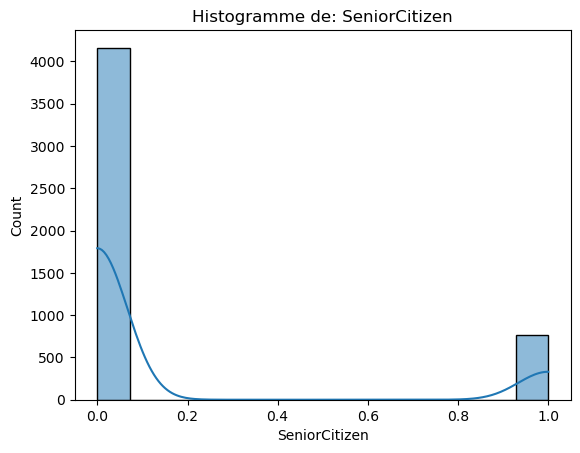

c:\Users\vigan\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


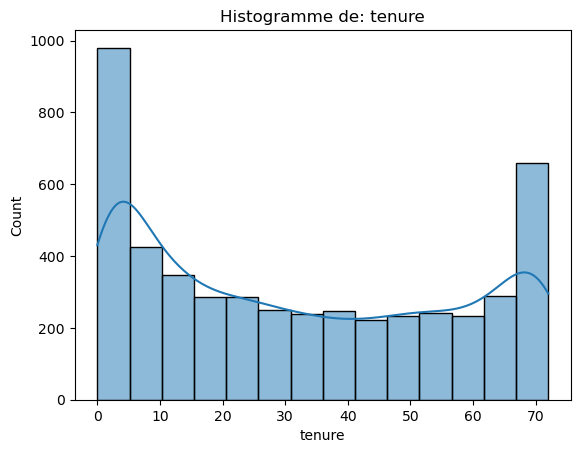

c:\Users\vigan\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


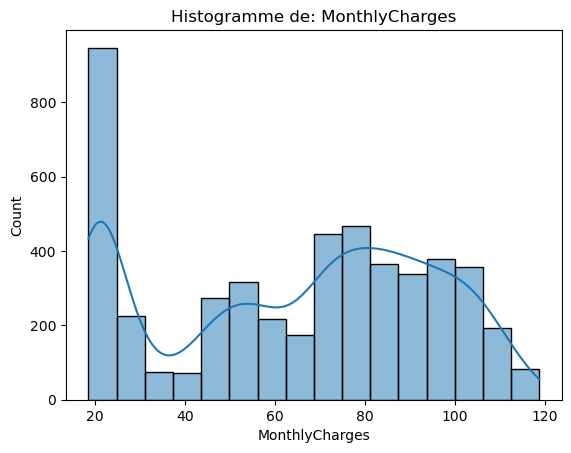

c:\Users\vigan\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


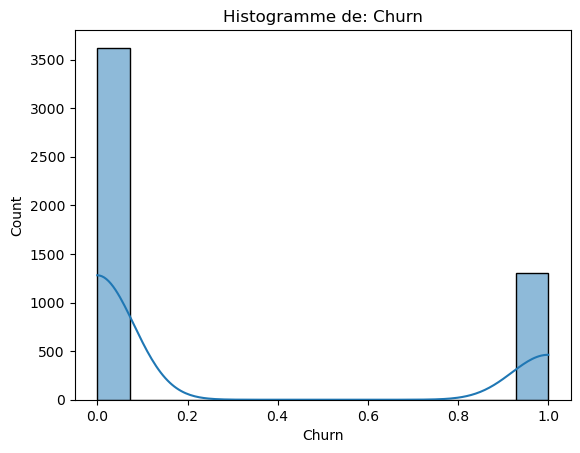

In [24]:
# Diagramme a barre de chaque variables quantitatives

for col in numerical:
    plt.figure()
    sns.histplot(data= train, x=train[col],kde=True)
    plt.title('Histogramme de: ' + col)
    plt.show()
    plt.close()


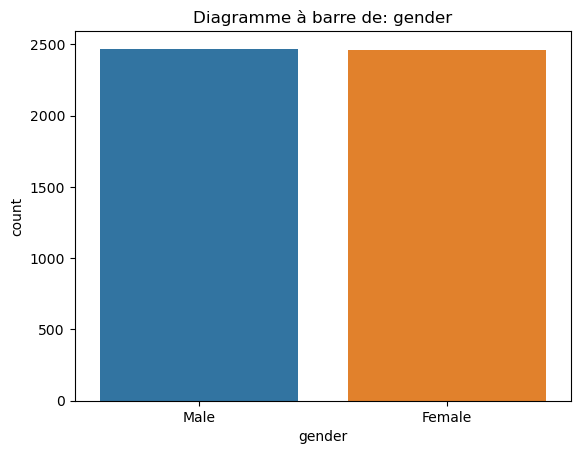

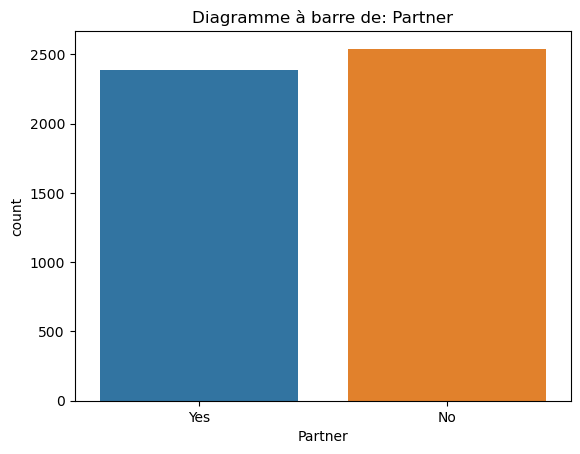

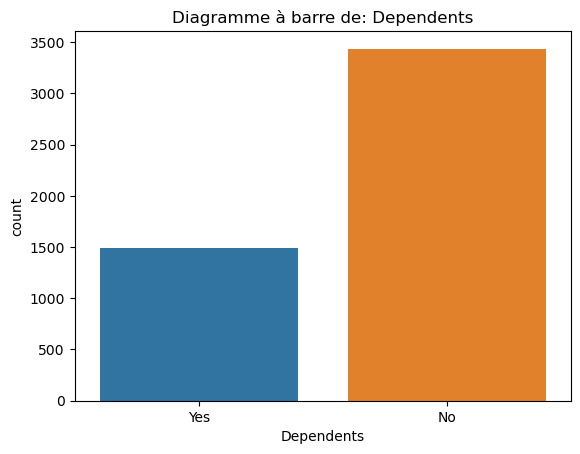

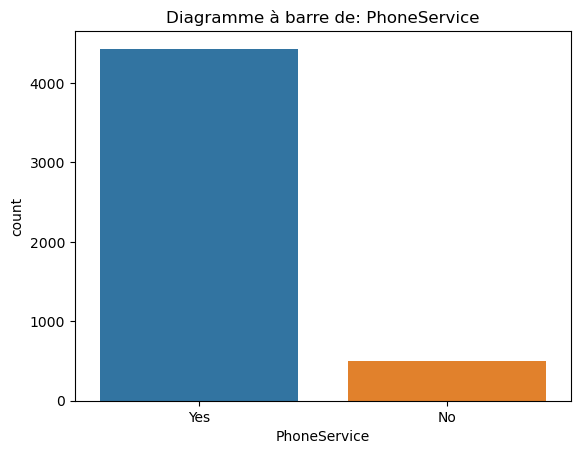

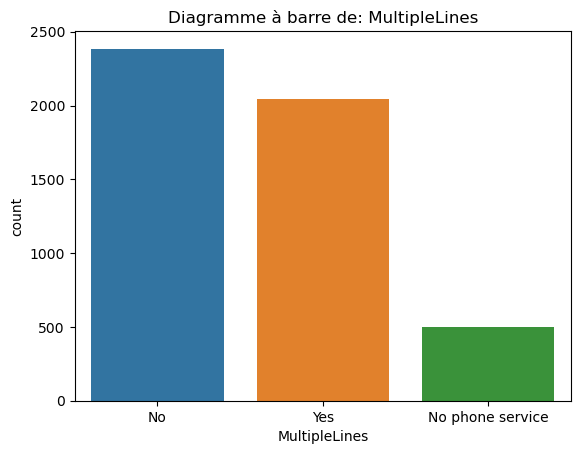

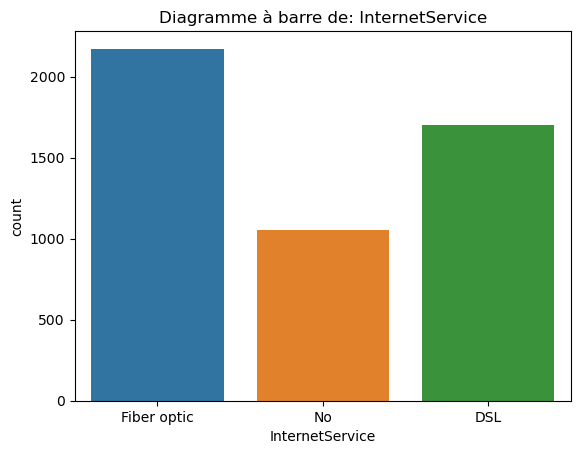

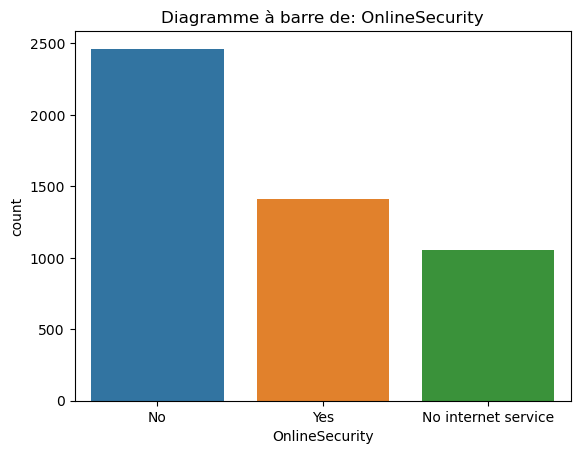

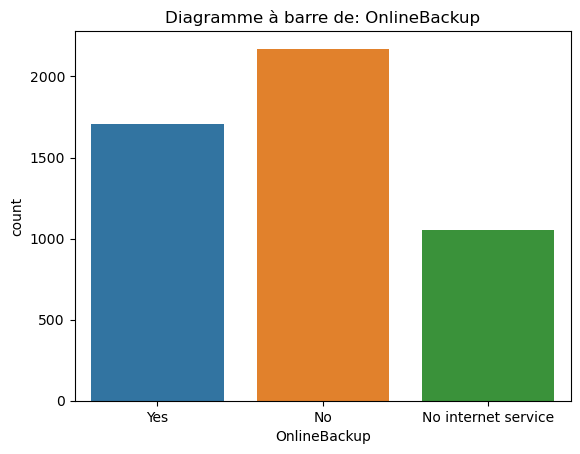

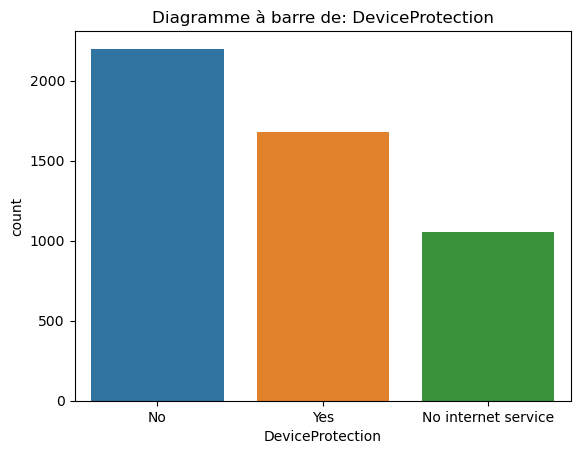

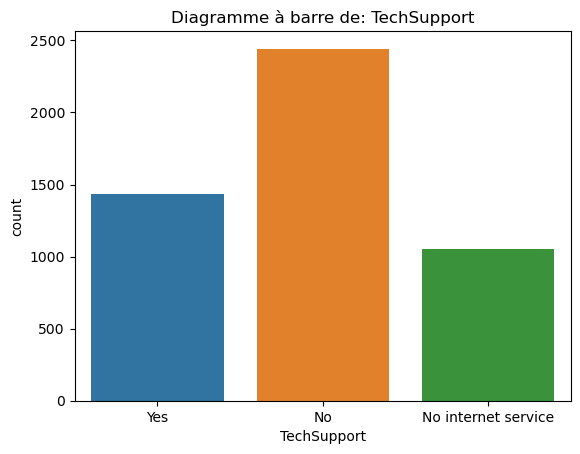

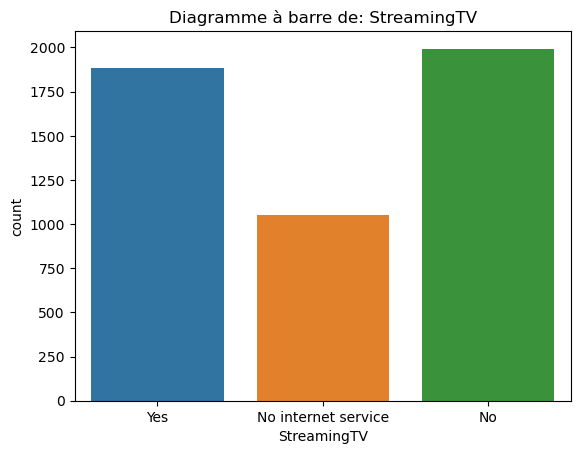

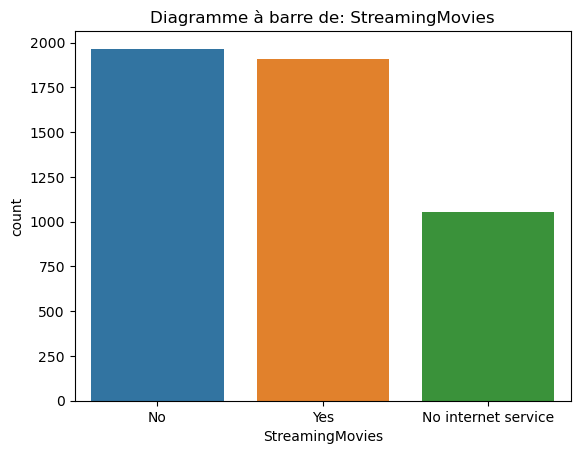

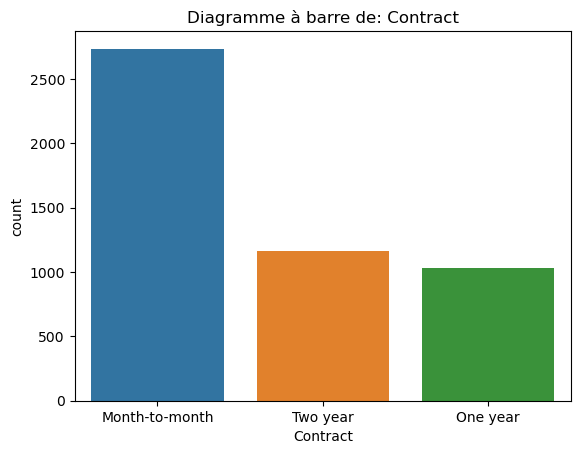

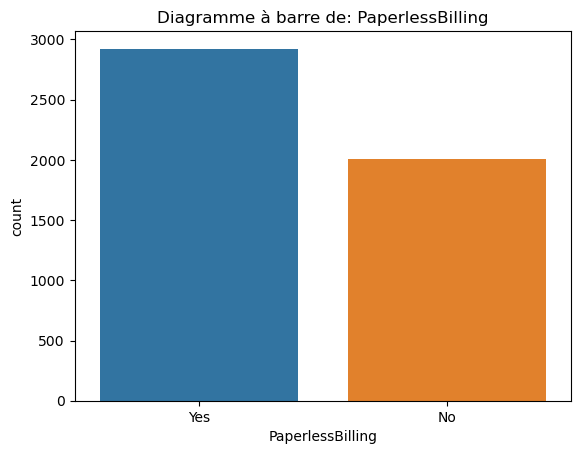

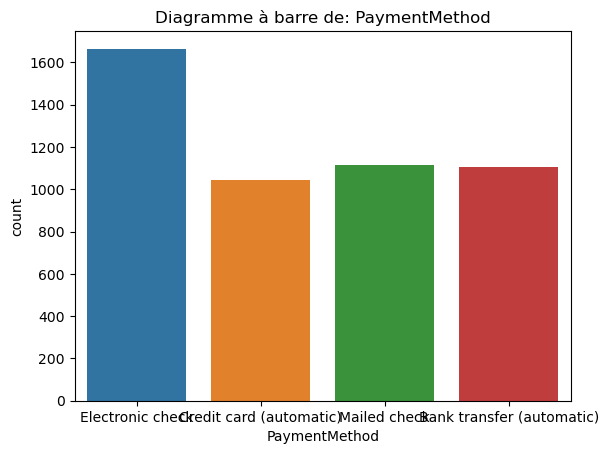

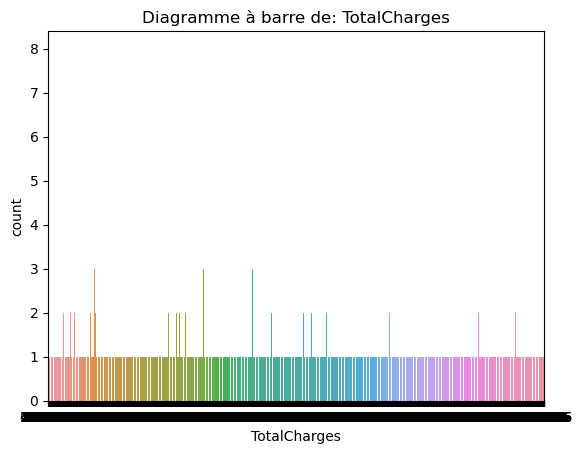

In [25]:
for col in categorical:
    plt.figure()
    sns.countplot(data=train, x=col)
    plt.title('Diagramme à barre de: ' +col)
    plt.show()
    plt.close()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


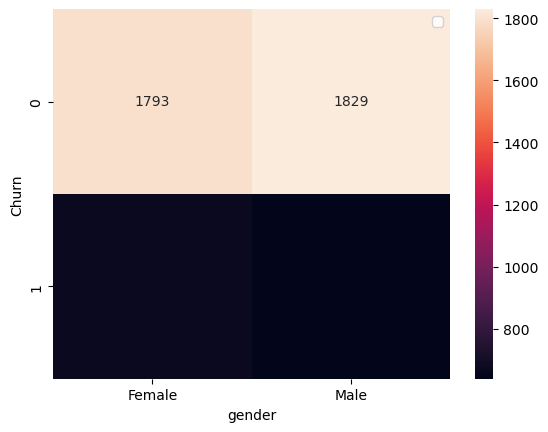

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


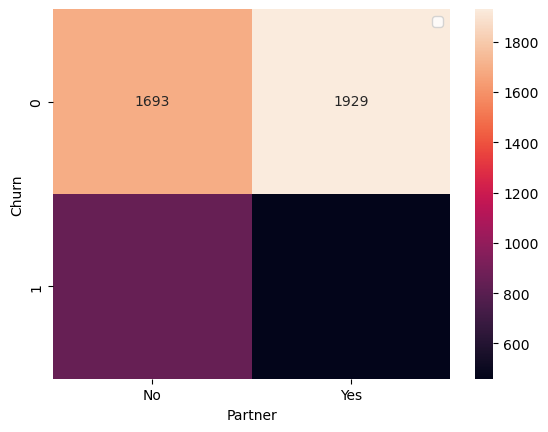

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


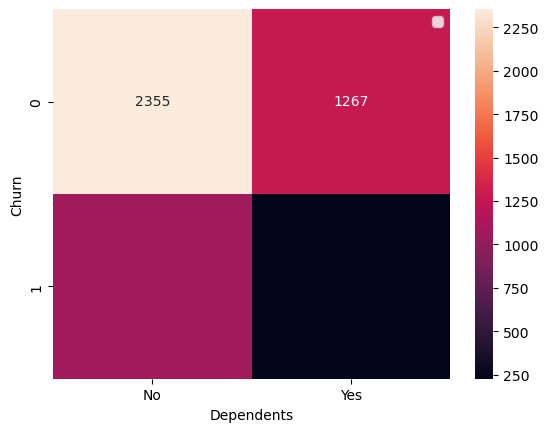

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


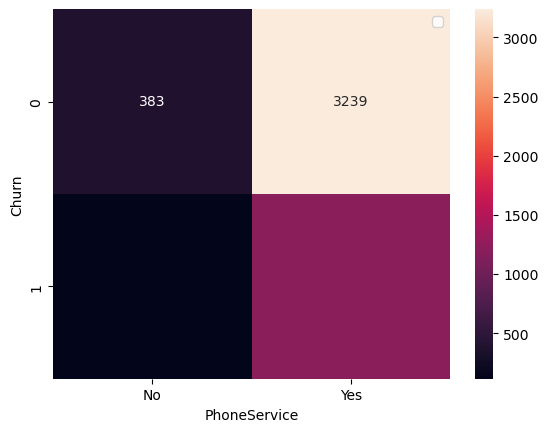

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


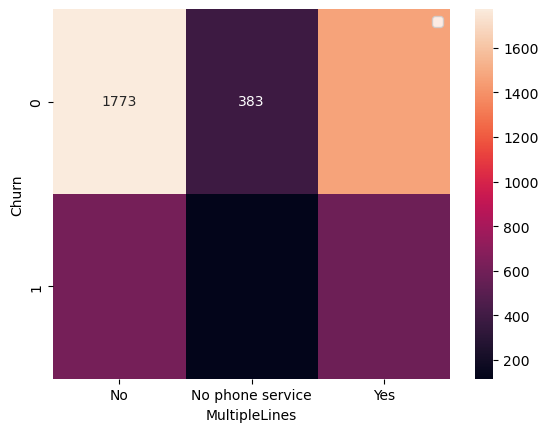

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


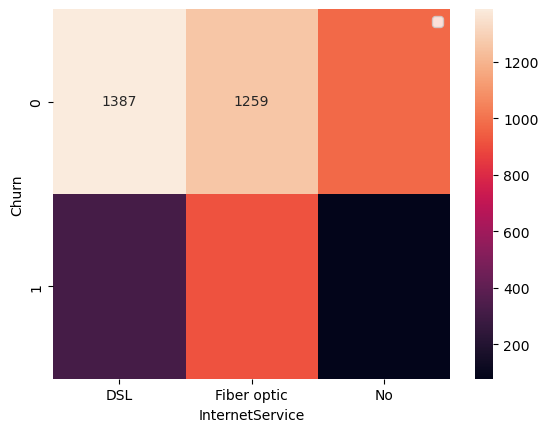

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


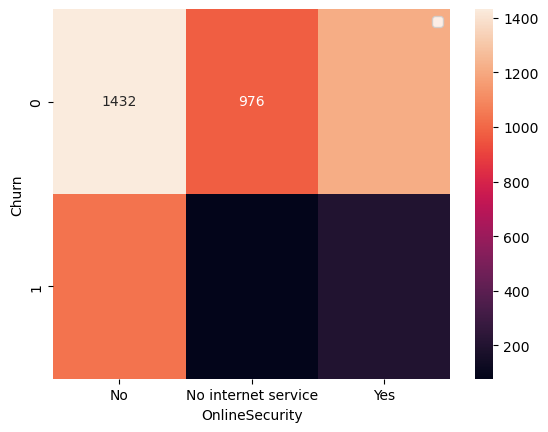

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


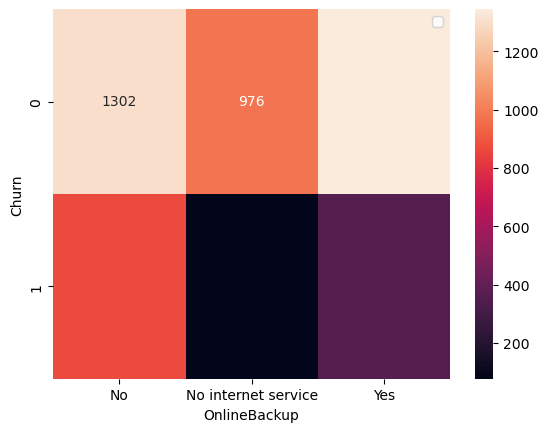

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


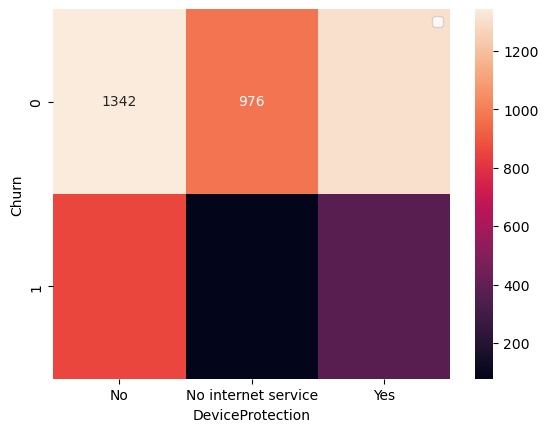

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


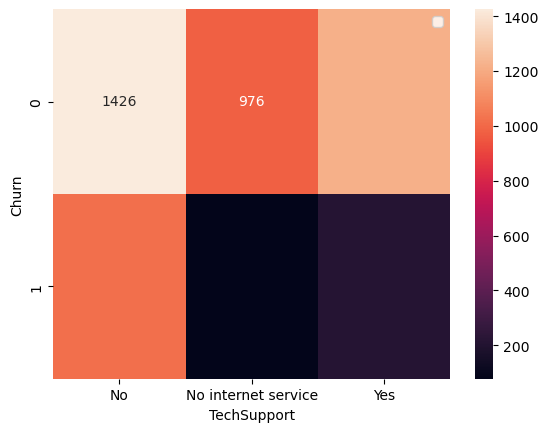

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


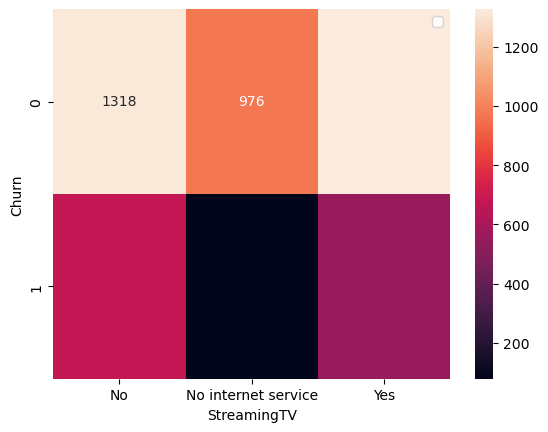

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


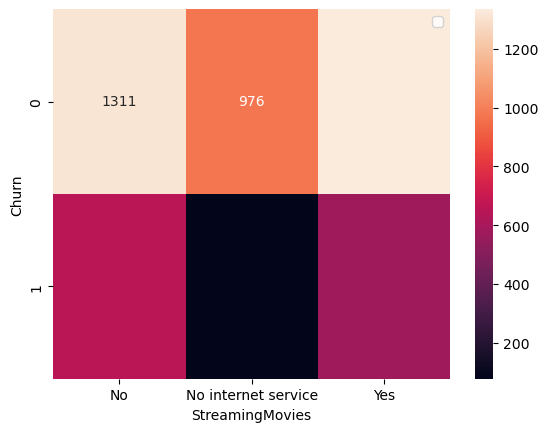

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


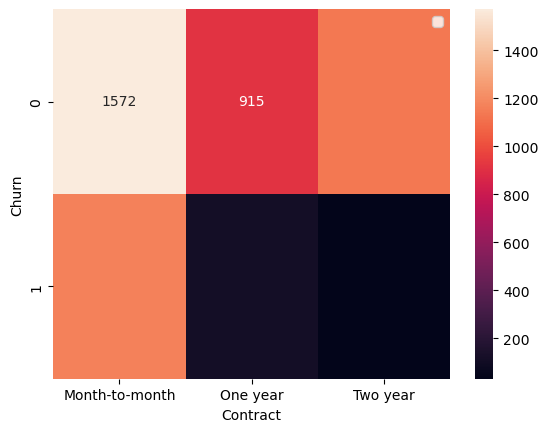

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


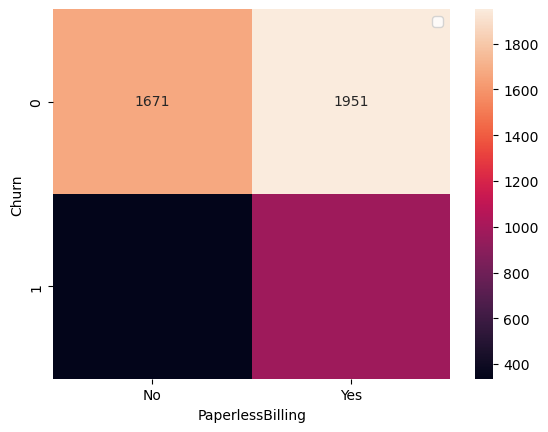

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


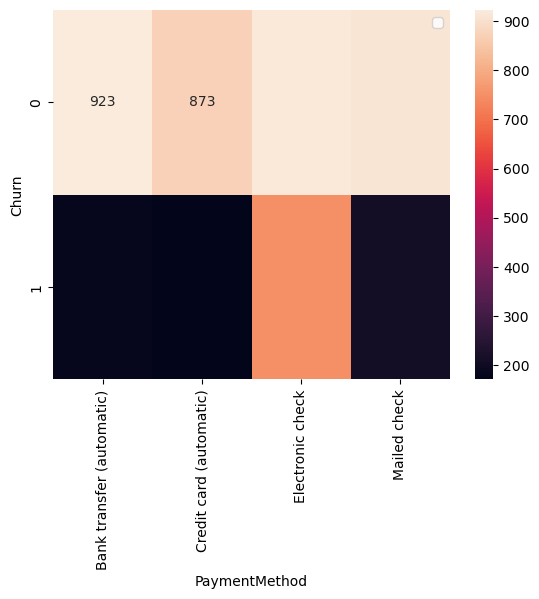

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


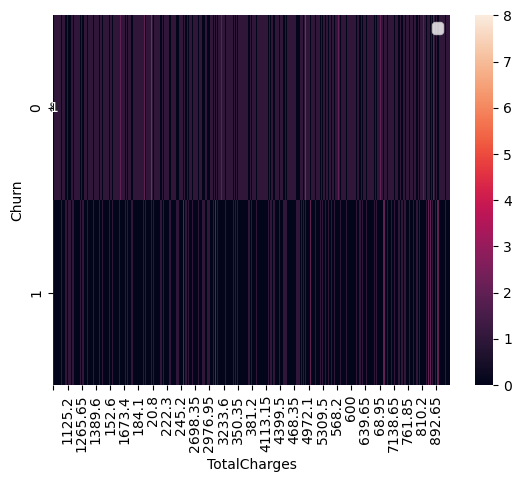

In [26]:
for col in categorical:
    plt.figure()
    sns.heatmap(pd.crosstab(train['Churn'],
                            train[col]), annot=True, fmt='d')
    plt.legend()
    plt.show()
    plt.close()

<Axes: >

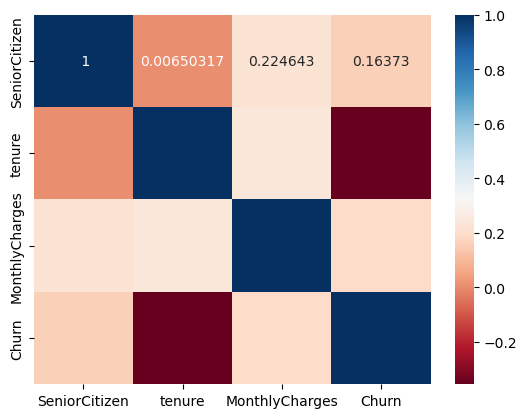

In [27]:
sns.heatmap(numerical.corr(), annot=True, cmap="RdBu", fmt='2g')

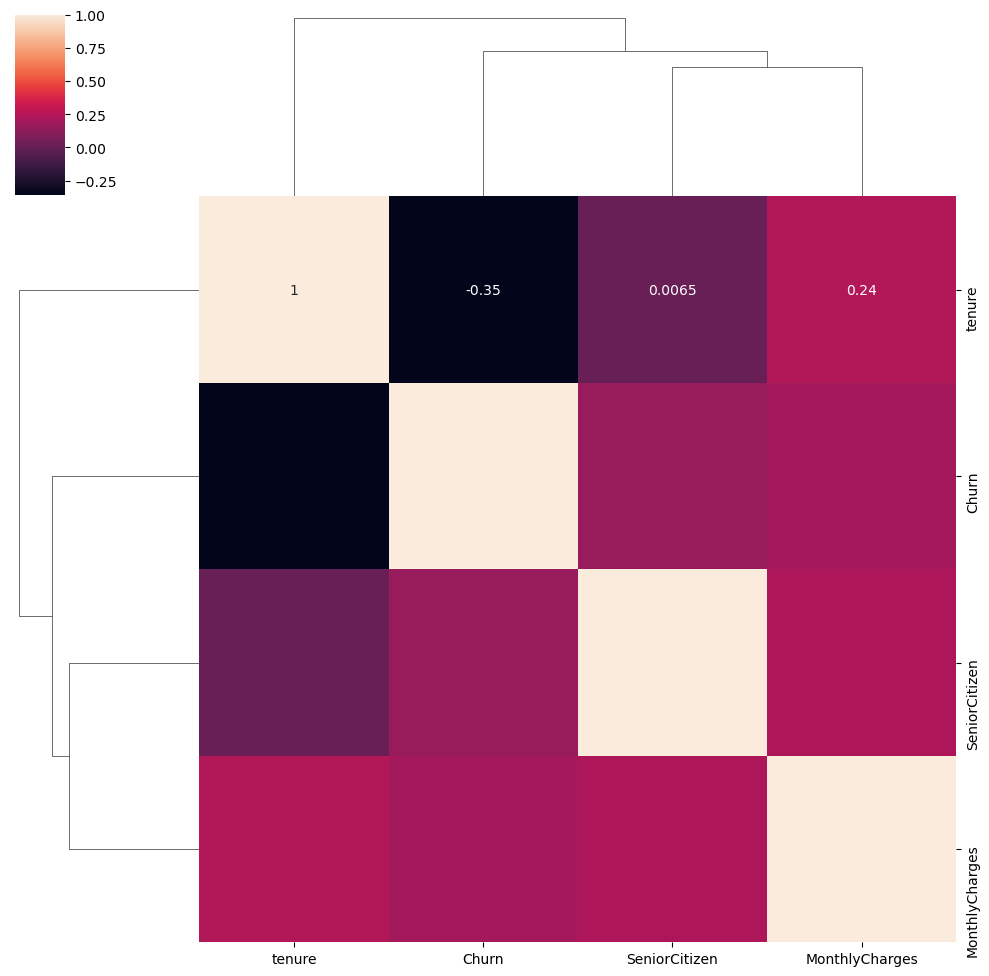

In [28]:
sns.clustermap(numerical.corr(), annot=True)

In [29]:
for col in categorical:
    print(f'{col:-<50} {train[col].unique()}')

gender-------------------------------------------- ['Male' 'Female']
Partner------------------------------------------- ['Yes' 'No']
Dependents---------------------------------------- ['Yes' 'No']
PhoneService-------------------------------------- ['Yes' 'No']
MultipleLines------------------------------------- ['No' 'Yes' 'No phone service']
InternetService----------------------------------- ['Fiber optic' 'No' 'DSL']
OnlineSecurity------------------------------------ ['No' 'Yes' 'No internet service']
OnlineBackup-------------------------------------- ['Yes' 'No' 'No internet service']
DeviceProtection---------------------------------- ['No' 'Yes' 'No internet service']
TechSupport--------------------------------------- ['Yes' 'No' 'No internet service']
StreamingTV--------------------------------------- ['Yes' 'No internet service' 'No']
StreamingMovies----------------------------------- ['No' 'Yes' 'No internet service']
Contract------------------------------------------ ['Month-to-

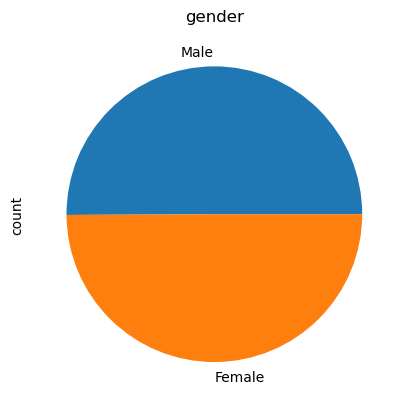

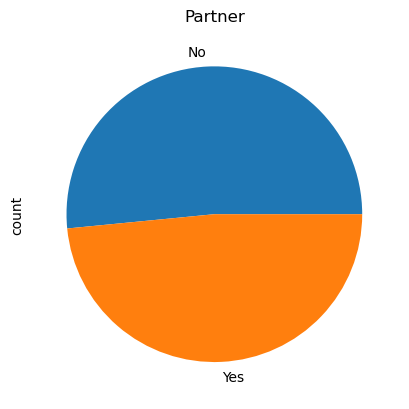

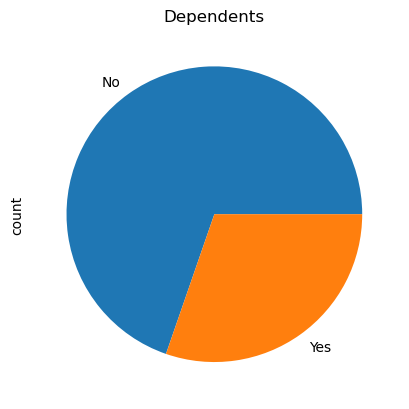

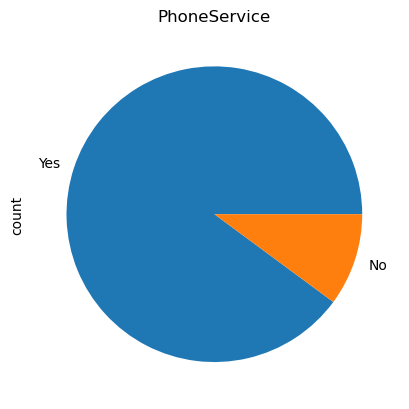

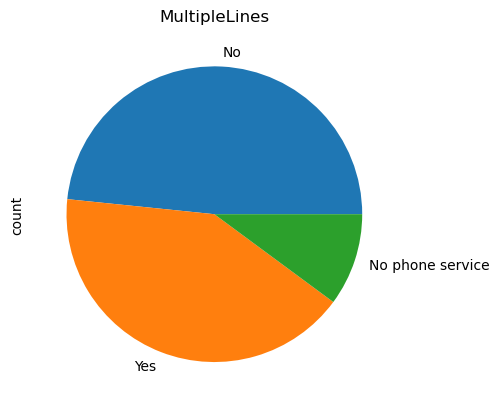

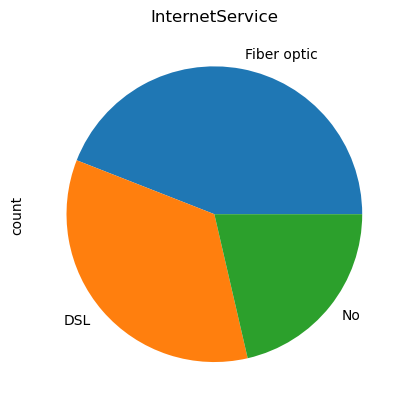

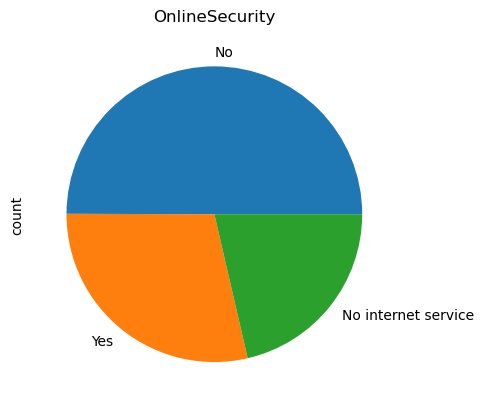

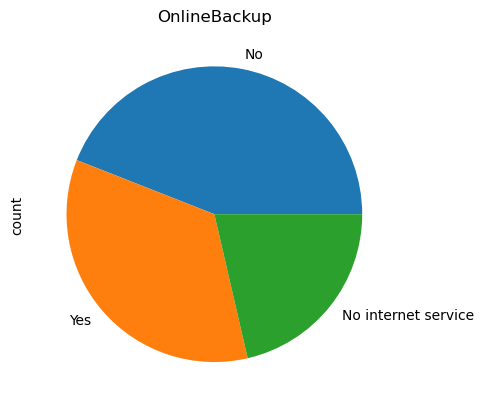

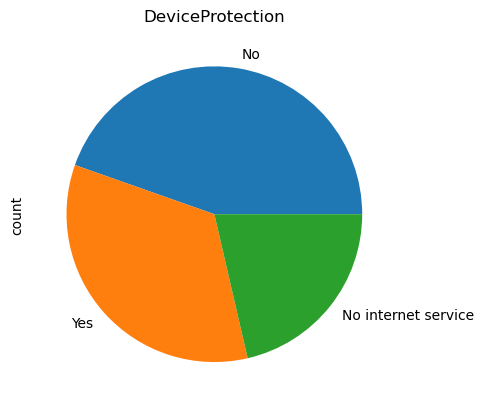

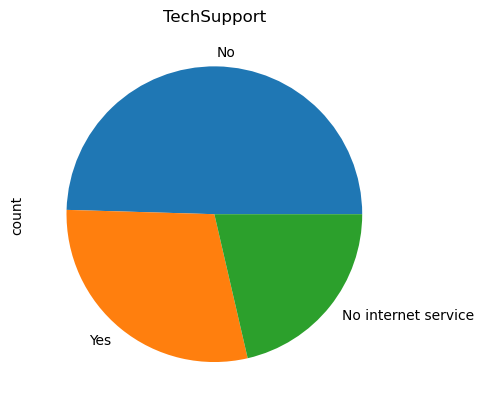

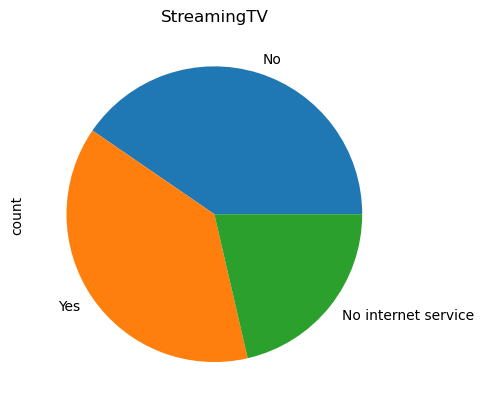

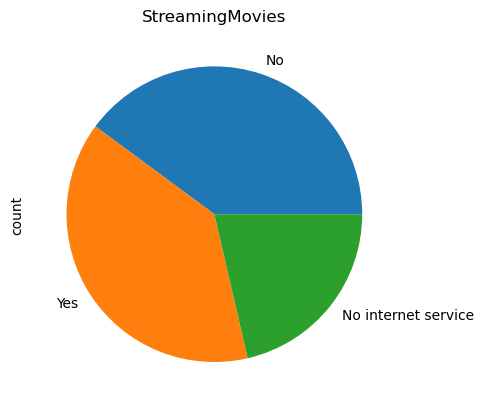

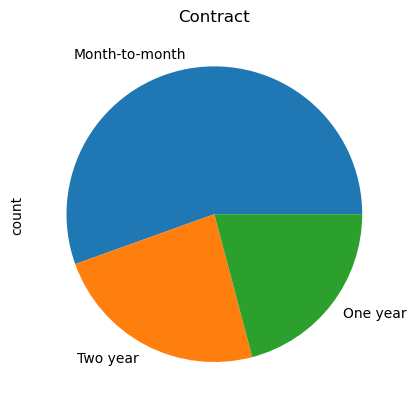

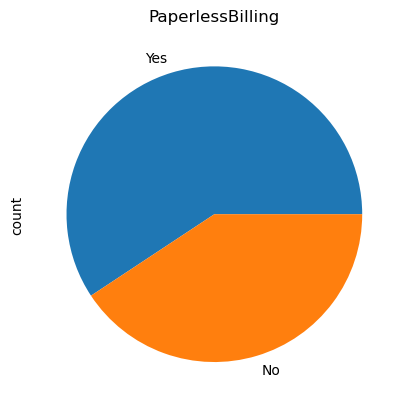

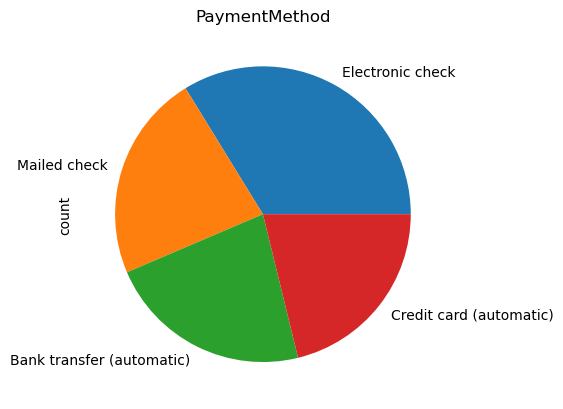

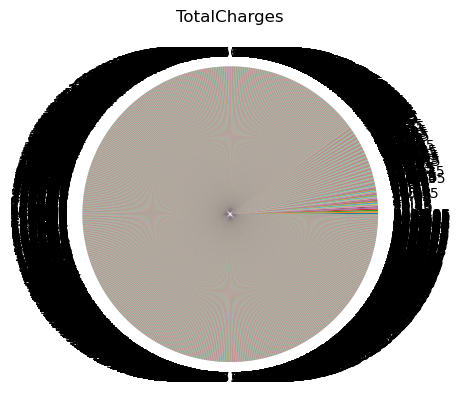

In [30]:
for col in categorical:
    plt.figure()
    train[col].value_counts().plot.pie()
    plt.title(col)

## Preprocessing

In [31]:
# Nous allons traiter la variable TotalCharges

def convert_total_charge(Z):
    '''
    Cette nous permettra de convertir les lignes vides de la variable TotalCharges en NaN et donc la convertir en float

    input:
          df = dataset
          column_name = 'TotalCharges'
    output:
          df modifie
    '''
    Z['TotalCharges'] = Z['TotalCharges'].replace(' ', np.nan).astype(float)
    return Z

In [32]:
train.head(4)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
4890,Male,0,Yes,Yes,53,Yes,No,Fiber optic,No,Yes,No,Yes,Yes,No,Month-to-month,Yes,Electronic check,92.55,4779.45,0
511,Male,0,No,No,61,Yes,Yes,Fiber optic,Yes,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,106.45,6300.15,0
169,Female,0,Yes,Yes,16,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Electronic check,20.40,321.4,0
3649,Male,0,Yes,Yes,71,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),25.35,1847.55,0


In [33]:
train = convert_total_charge(train)
valide = convert_total_charge(validate)

In [34]:
train['TotalCharges'].dtype

dtype('float64')

In [35]:
train.dtypes.value_counts()

object     15
int64       3
float64     2
Name: count, dtype: int64

In [36]:
def cut_x_y(df):
    y = df['Churn']
    x = df.drop('Churn', axis=1)

    return x, y

In [37]:
x_train, y_train = cut_x_y(train)
x_val, y_val = cut_x_y(valide)

In [38]:
numerical_df = make_column_selector(dtype_include=np.number)
categorical_df = make_column_selector(dtype_exclude=np.number)

In [39]:
numerical_df

In [40]:
# Pileline de preprocessing

numerical_transformer = Pipeline(steps= [('imputer', SimpleImputer(strategy='most_frequent')),
                                      ('standard', StandardScaler())])

categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder())])

In [41]:
preprocessing = ColumnTransformer(transformers= [('numeric', numerical_transformer, numerical_df),
                                        ('categorial', categorical_transformer, categorical_df)])

In [42]:
preprocessing

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('standard',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001D58922DC10>),
                                ('categorial',
                                 Pipeline(steps=[('encoder', OneHotEncoder())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001D58922E550>)])

## Modelisation

In [43]:
RandomForest = make_pipeline(preprocessing, RandomForestClassifier(random_state=seed))

KNN = make_pipeline(preprocessing, KNeighborsClassifier())

SVM = make_pipeline(preprocessing, SVC(random_state=seed))

ADA = make_pipeline(preprocessing, AdaBoostClassifier(random_state=seed))

Log_regre = make_pipeline(preprocessing, LogisticRegression(random_state=seed))

In [44]:
dict_model = {'RandomForestClassifier' : RandomForest,
              'KNeighborsClassifier': KNN,
              'SVC': SVM,
              'AdaBoostClassifier' : ADA,
              'LogisticRegression' : Log_regre}

In [45]:
def evaluation(model, name):
    model.fit(x_train, y_train)
    y_val_pred = model.predict(x_val)

    print(confusion_matrix(y_val, y_val_pred))
    print(classification_report(y_val, y_val_pred))

    N, train_score, val_score = learning_curve(model , x_train, y_train, cv=4,
                                            train_sizes=np.linspace(0.1, 1, 10))
    
   
    
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.title(name)
    plt.legend()

RandomForestClassifier
[[690  86]
 [163 118]]
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       776
           1       0.58      0.42      0.49       281

    accuracy                           0.76      1057
   macro avg       0.69      0.65      0.67      1057
weighted avg       0.75      0.76      0.75      1057

KNeighborsClassifier
[[651 125]
 [144 137]]
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       776
           1       0.52      0.49      0.50       281

    accuracy                           0.75      1057
   macro avg       0.67      0.66      0.67      1057
weighted avg       0.74      0.75      0.74      1057

SVC
[[709  67]
 [163 118]]
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       776
           1       0.64      0.42      0.51       281

    accuracy                           0.78      1057
   macro av

c:\Users\vigan\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\vigan\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

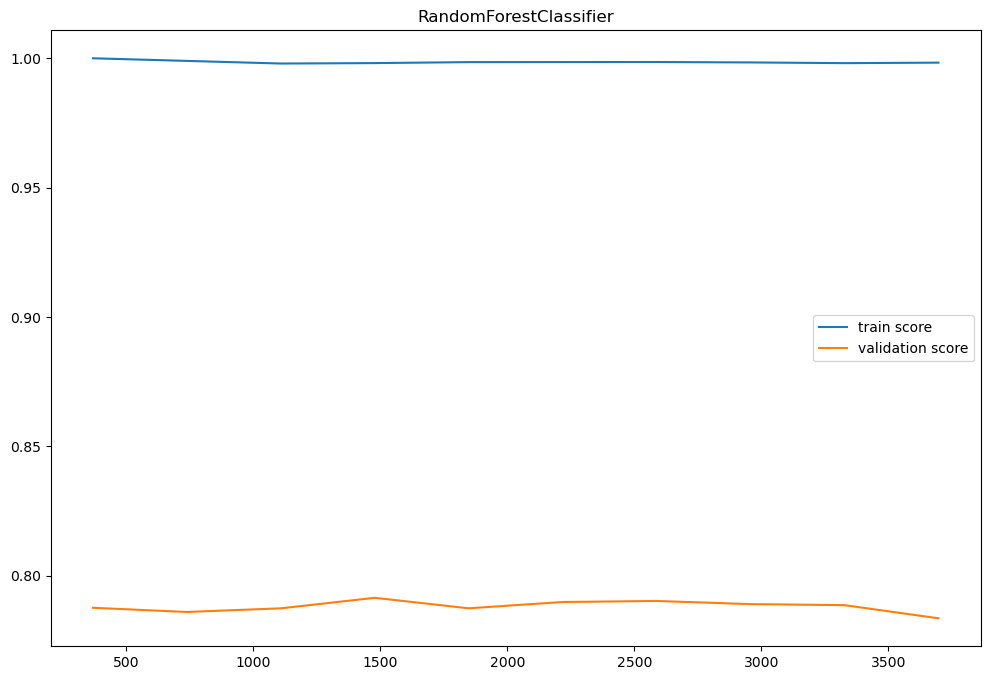

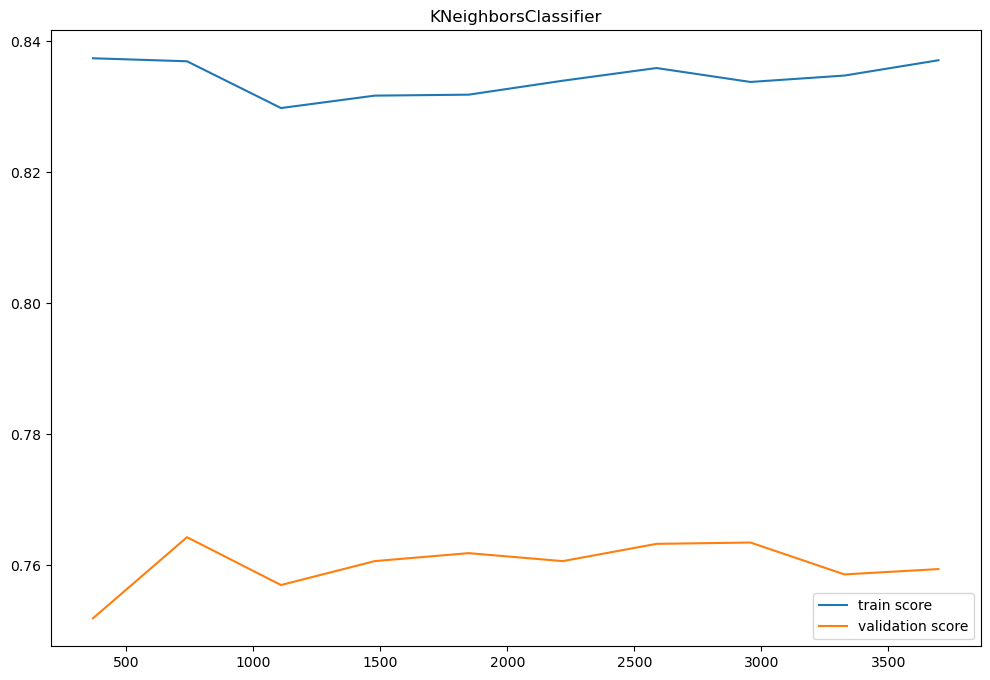

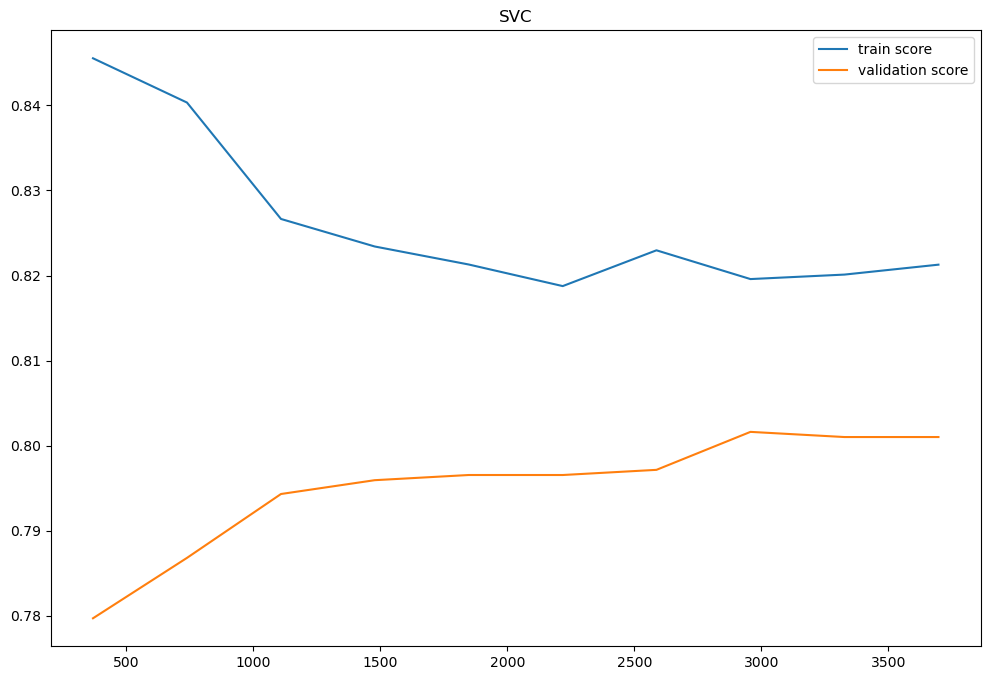

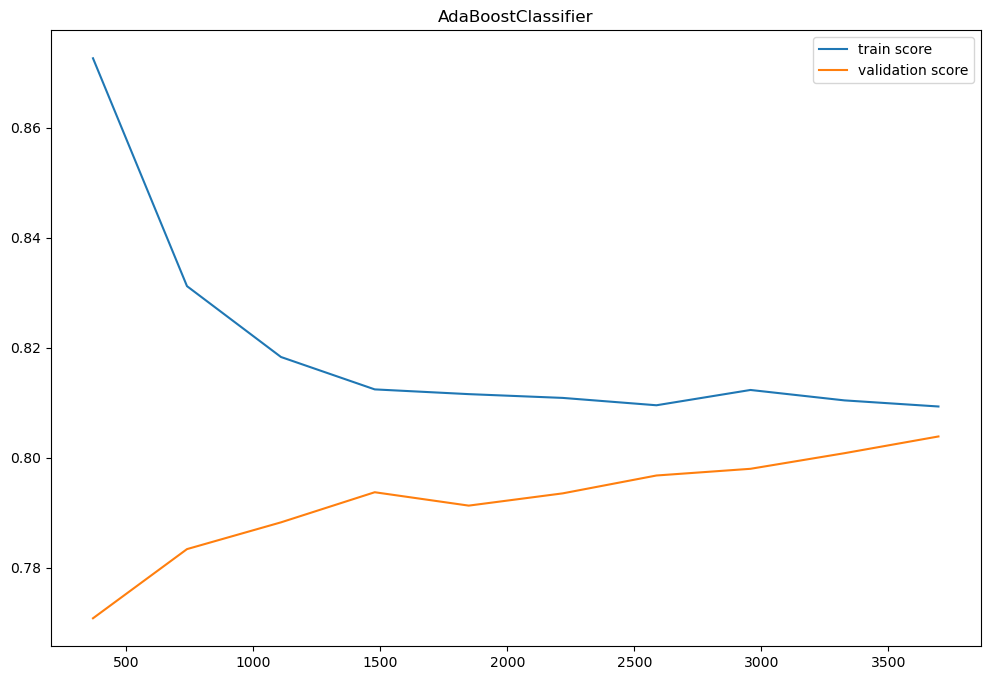

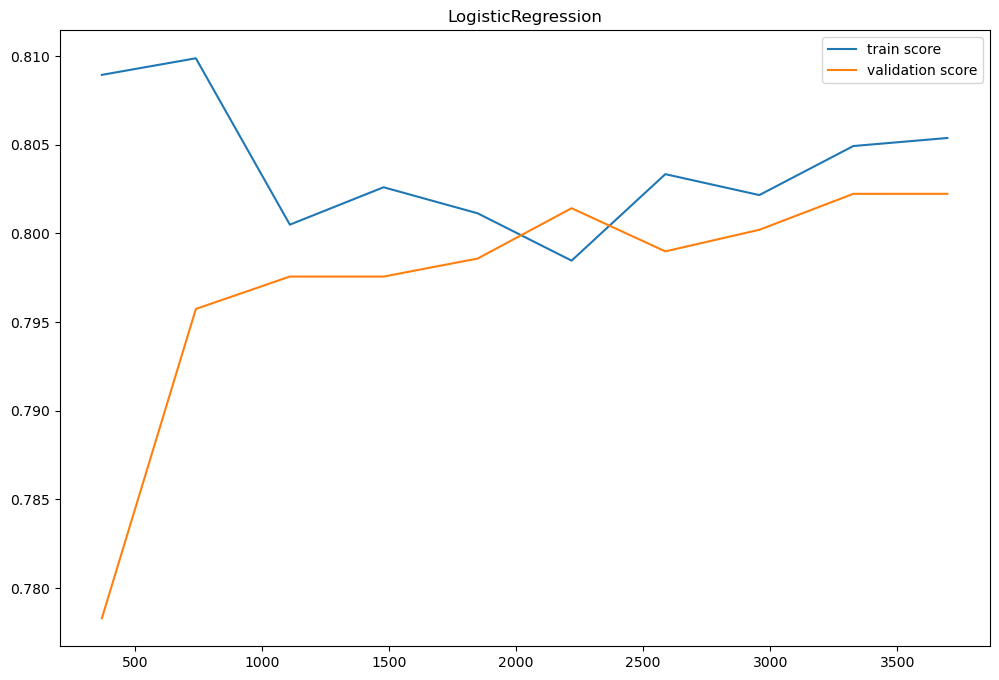

In [46]:
for name, model in dict_model.items():
    print(name)
    evaluation(model, name)

### Optimisation et réglage des hyperparamètres

Je choisis de model de regression logistic car cela a la meilleure performance

In [47]:
model_log = Pipeline(
    steps= [
        ('preprocessor', preprocessing),
        ('regression_logistic', LogisticRegression(random_state=0, max_iter=1000))
    ]
)

params = {
    'regression_logistic__solver' : ['lbfgs',  'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'regression_logistic__penalty' : ['l2', None],
    'regression_logistic__C' : [0.5, 1.0, 5.0, 10.0]
}


model = GridSearchCV(
    estimator=model_log, param_grid=params, 
    cv=5, n_jobs=-1
)


model.fit(x_train, y_train)

c:\Users\vigan\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('standard',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001D58922DC10>),
                                                                        ('categorial',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder())]),
                                                                         <...n.compose._column_transformer.make_column_selector object at 0x000001D58922E550>)])),
                                       ('regression_logistic',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=0))]),
             n_jobs=-1,
             param_grid={'regression_logistic__C': [0.5, 1.0, 5.0, 10.0],
                         'regression_logistic__penalty': ['l2', None],
                         'regression_logistic__solver': ['lbfgs', 'newton-cg',
                                                         'newton-cholesky',
                                                         'sag', 'saga']})

In [48]:
model.best_params_

{'regression_logistic__C': 0.5,
 'regression_logistic__penalty': None,
 'regression_logistic__solver': 'lbfgs'}

In [49]:
model.best_score_

0.8030425963488843

In [50]:
modele = Pipeline(
    steps= [
        ('preprocessor', preprocessing),
        ('regression_logistic', LogisticRegression(random_state=0, max_iter=1000,C= 0.5,
                                        penalty= None,
                                        solver= 'lbfgs' ))
    ]
)


In [51]:
modele.fit(x_train, y_train)

c:\Users\vigan\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('standard',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D58922DC10>),
                                                 ('categorial',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D58922E550>)])),
                ('regression_logistic',
                 LogisticRegression(C=0.5, max_iter=1000, penalty=None,
                                    random_state=0))])

In [52]:
y_p = modele.predict(x_val)

In [53]:
print(classification_report(y_val, y_p))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       776
           1       0.62      0.48      0.54       281

    accuracy                           0.78      1057
   macro avg       0.72      0.69      0.70      1057
weighted avg       0.77      0.78      0.77      1057



In [54]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(modele, x_train, y_train, cv=5)
print(f'Scores de validation croisée : {scores}')
print(f'Moyenne des scores : {scores.mean()}')


c:\Users\vigan\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\vigan\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\vigan\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\vigan\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Scores de validation croisée : [0.79513185 0.80425963 0.77991886 0.81440162 0.82150101]
Moyenne des scores : 0.8030425963488843


c:\Users\vigan\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


In [55]:
# Enregistrement du meilleur modèle
joblib.dump(model.best_estimator_, './models/best_model.pkl')


['./models/best_model.pkl']

In [56]:
# Chargement du meilleur modele
loaded_model = joblib.load('./models/best_model.pkl')
loaded_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('standard',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D583473D50>),
                                                 ('categorial',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D5834B4990>)])),
                ('regression_logistic',
                 LogisticRegression(C=0.5, max_iter=1000, penalty=None,
                                    random_state=0))])

In [58]:
testset = convert_total_charge(test)

x_test, y_test = cut_x_y(testset)

              precision    recall  f1-score   support

           0       0.86      0.91      0.89       776
           1       0.71      0.58      0.64       280

    accuracy                           0.83      1056
   macro avg       0.78      0.75      0.76      1056
weighted avg       0.82      0.83      0.82      1056



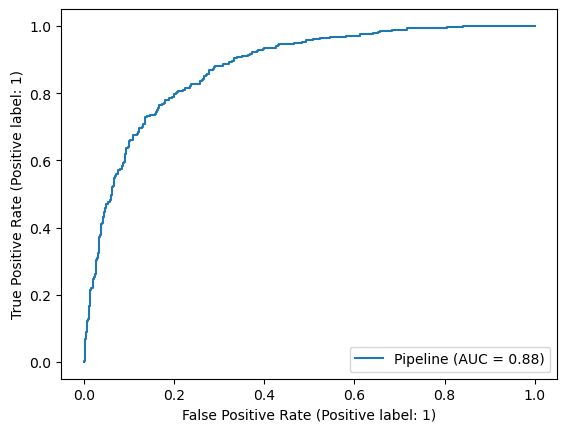

In [61]:
# Prédiction sur les données du test
y_test_preds = loaded_model.predict(x_test)

# Rapport de classification
print(classification_report(y_test, y_test_preds))

# Courbe ROC
roc_plot = RocCurveDisplay.from_estimator(loaded_model, x_test, y_test)